In [1]:
import numpy as np
df=np.load("/Users/rohitviswam/Downloads/CSI-02-0005/H_32T4R_30_1RB.npy")
data=df.reshape(2100,398,256)
data.shape
feature_len=data.shape[-1]

In [2]:
data = data[:5]

In [3]:
data.shape

(5, 398, 256)

In [4]:
import numpy as np
import torch
from iTransformer import iTransformer
from iTransformer import iTransformer2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
# data_flattened = data.reshape(data.shape[0], -1)  # shape becomes (2100, 398*256)


In [6]:
# data = data_flattened

In [7]:
import numpy as np
import torch

# Assuming `data` is already loaded and is of shape (2100, 398, 256)

def preprocess_UE_data(data, lookback_len=10):
    """
    Preprocesses data to create input-target pairs.
    Args:
        data: numpy array, (2100, 398, 256), original dataset
        lookback_len: int, number of past timesteps to consider as input
    
    Returns:
        inputs: torch Tensor, shape (samples, lookback_len, features)
        targets: torch Tensor, shape (samples, features)
    """
    num_UEs, num_timesteps, num_features = data.shape
    input_list = []
    target_list = []

    for ue in range(num_UEs):
        ue_data = data[ue]
        for i in range(num_timesteps - lookback_len):
            input_seq = ue_data[i: i + lookback_len]
            target_seq = ue_data[i + lookback_len]
            
            input_list.append(input_seq)
            target_list.append(target_seq)

    inputs = torch.tensor(input_list, dtype=torch.float32)
    targets = torch.tensor(target_list, dtype=torch.float32)

    return inputs, targets

# Usage example
inputs, targets = preprocess_UE_data(data, lookback_len=10)

print("Input shape:", inputs.shape)   # Expected: (samples, 10, 256)
print("Target shape:", targets.shape) # Expected: (samples, 256)


Input shape: torch.Size([1940, 10, 256])
Target shape: torch.Size([1940, 256])


/var/folders/s4/8jqt5cd174q2hllds_77s79r0000gn/T/ipykernel_13902/93298084.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  inputs = torch.tensor(input_list, dtype=torch.float32)


In [8]:
import torch
import torch.nn as nn
from iTransformer import iTransformer

# Set up parameters and data
num_UEs, num_timesteps, num_features = data.shape
lookback_len = 10
forecast_len = 1


# Define the iTransformer model
model = iTransformer2D(
    num_variates=num_features,
    lookback_len=lookback_len,
    dim=256,           # Model dimension
    depth=6,           # Number of layers
    heads=8,           # Number of attention heads
    dim_head=64,       # Dimension per head
    pred_length=forecast_len,  # Prediction horizon (1 in this case)
    num_time_tokens=1,  # Single token per variate
    use_reversible_instance_norm=True
)



In [9]:
from torchinfo import summary

# Assuming your model object is already defined as `model`

# Generate a model summary (batch size and input dimensions as required)
model_summary = summary(model, input_size=(64, 10, 256))  # Adjust batch size and input size accordingly

# This will print a detailed summary with parameters, layers, and dimensions
print(model_summary)


Layer (type:depth-idx)                        Output Shape              Param #
iTransformer                                  [64, 1, 256]              1,024
├─RevIN: 1-1                                  [64, 256, 10]             (512)
├─Sequential: 1-2                             [64, 256, 256]            --
│    └─Linear: 2-1                            [64, 256, 256]            2,816
│    └─Rearrange: 2-2                         [64, 256, 256]            --
│    └─LayerNorm: 2-3                         [64, 256, 256]            512
├─ModuleList: 1-3                             --                        --
│    └─ModuleList: 2-4                        --                        --
│    │    └─Attention: 3-1                    [64, 260, 256]            655,360
│    │    └─LayerNorm: 3-2                    [64, 260, 256]            512
│    │    └─Sequential: 3-3                   [64, 260, 256]            525,396
│    │    └─LayerNorm: 3-4                    [64, 260, 256]            51

In [10]:
# Print the architecture by directly printing the model object
print(model)


iTransformer(
  (reversible_instance_norm): RevIN()
  (layers): ModuleList(
    (0-5): 6 x ModuleList(
      (0): Attention(
        (to_qkv): Sequential(
          (0): Linear(in_features=256, out_features=1536, bias=False)
          (1): Rearrange('b n (qkv h d) -> qkv b h n d', qkv=3, h=8)
        )
        (to_v_gates): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=False)
          (1): SiLU()
          (2): Rearrange('b n (h d) -> b h n d', h=8)
        )
        (attend): Attend(
          (attn_dropout): Dropout(p=0.0, inplace=False)
        )
        (to_out): Sequential(
          (0): Rearrange('b h n d -> b n (h d)')
          (1): Linear(in_features=512, out_features=256, bias=False)
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): Sequential(
        (0): Linear(in_features=256, out_features=1364, bias=True)
        (1): GEGLU()
        (2): Dropout(p=0.0, 

In [11]:
# Define training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

inputs = inputs.to(device)
targets = targets.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
batch_size = 64

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = int(len(inputs) / batch_size)
    
    for batch in range(num_batches):
     batch_inputs = inputs[batch * batch_size:(batch + 1) * batch_size]
     batch_targets = targets[batch * batch_size:(batch + 1) * batch_size]

     optimizer.zero_grad()
     preds = model(batch_inputs)[forecast_len].squeeze(1)  # Remove the singleton dimension
     loss = criterion(preds, batch_targets)
     loss.backward()
     optimizer.step()
     epoch_loss += loss.item()


    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / num_batches:.4f}")


Epoch 1/10, Loss: 0.6025
Epoch 2/10, Loss: 0.2324
Epoch 3/10, Loss: 0.3831
Epoch 4/10, Loss: 0.3485
Epoch 5/10, Loss: 0.1800
Epoch 6/10, Loss: 0.1447
Epoch 7/10, Loss: 0.0933
Epoch 8/10, Loss: 0.0682
Epoch 9/10, Loss: 0.0609
Epoch 10/10, Loss: 0.0810


In [12]:
import pandas as pd

def tabulate_predictions(inputs, targets, model, forecast_len=1, batch_size=64):
    """
    Tabulates actual vs. predicted results.
    Args:
        inputs: torch Tensor, input data used to predict
        targets: torch Tensor, actual target values
        model: trained PyTorch model for making predictions
        forecast_len: int, how many timesteps to forecast
        batch_size: int, batch size to use in prediction

    Returns:
        DataFrame containing actual and predicted results.
    """
    model.eval()
    all_preds = []
    all_targets = []

    num_batches = int(len(inputs) / batch_size)

    with torch.no_grad():
        for batch in range(num_batches):
            batch_inputs = inputs[batch * batch_size:(batch + 1) * batch_size]
            batch_targets = targets[batch * batch_size:(batch + 1) * batch_size]

            # Predict using the model
            preds = model(batch_inputs)[forecast_len].squeeze(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())

    # Create DataFrame for easier tabulation and analysis
    df_results = pd.DataFrame({
        'Actual': [list(target) for target in all_targets],
        'Predicted': [list(pred) for pred in all_preds]
    })

    return df_results

# Example Usage:
results_df = tabulate_predictions(inputs, targets, model, forecast_len=1, batch_size=64)
print(results_df.head())  # Print the first few rows to verify


                                              Actual  \
0  [-0.239427, -1.60581, 1.01509, 0.00719427, 0.2...   
1  [1.24814, -0.465003, -0.233288, 1.16484, -0.53...   
2  [1.5201, 1.36986, -1.4114, 0.600414, -0.881511...   
3  [-0.0421607, 1.57827, -0.918438, -1.1427, -0.3...   
4  [-1.5537, 0.0603431, 0.674971, -1.67358, 0.672...   

                                           Predicted  
0  [-0.8152826, -1.0013723, 0.85062844, -0.564097...  
1  [0.74031556, -1.1081936, -0.1405555, 0.7268098...  
2  [0.78408706, 0.98088276, -1.0741688, 0.8025059...  
3  [-0.56601024, 1.0528319, -1.1507028, -0.872030...  
4  [-1.0920982, -0.7627628, 0.88291585, -1.034177...  


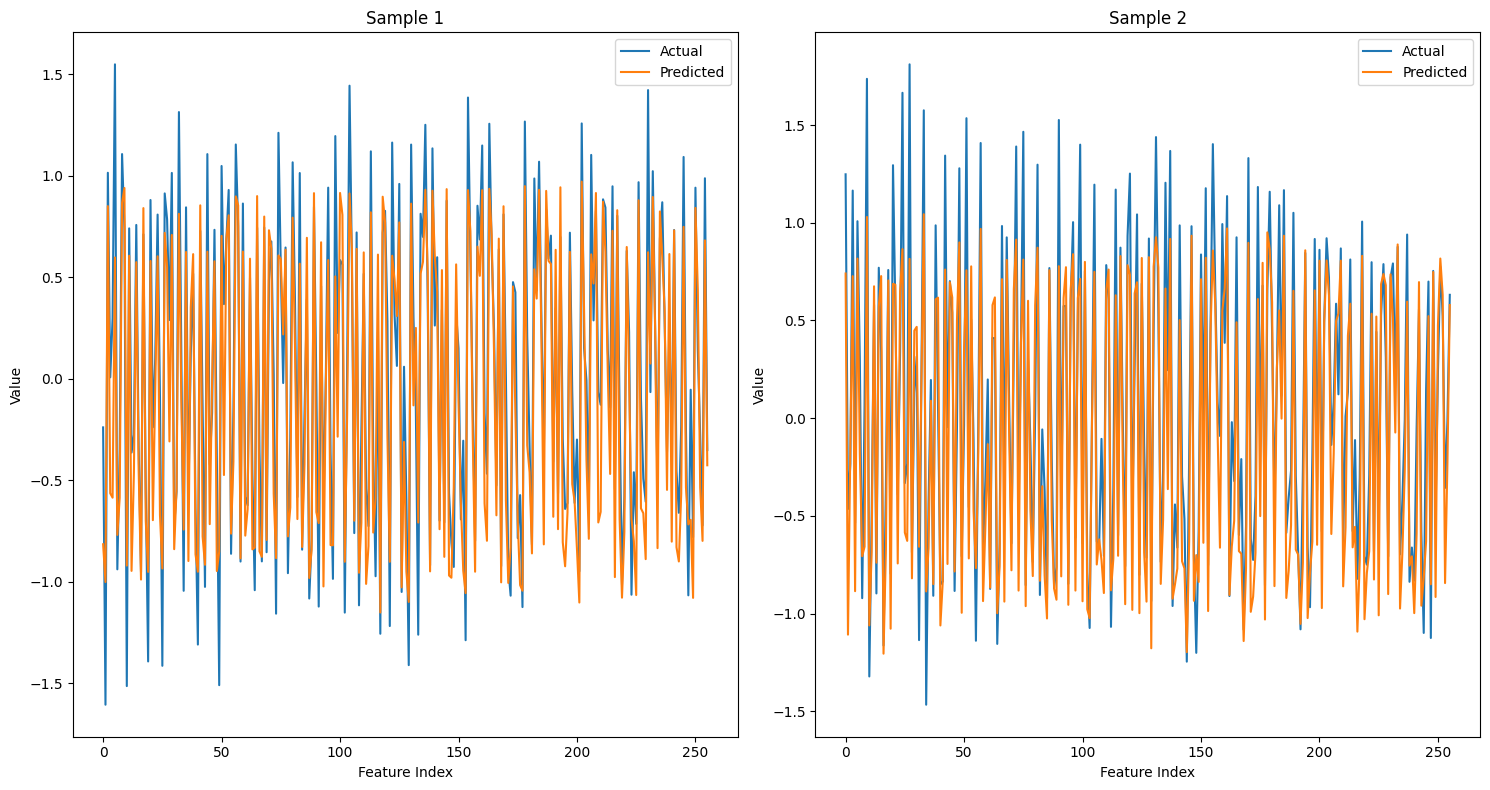

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(inputs, targets, model, forecast_len=1, num_samples=10, batch_size=64):
    """
    Plots a comparison between actual and predicted values.
    Args:
        inputs: torch Tensor, input data used to predict
        targets: torch Tensor, actual target values
        model: trained PyTorch model for making predictions
        forecast_len: int, how many timesteps to forecast
        num_samples: int, how many samples to plot
        batch_size: int, batch size to use in prediction

    Returns:
        None. Displays the plots.
    """
    model.eval()
    predictions = []
    actuals = []

    num_batches = min(int(len(inputs) / batch_size), num_samples)

    with torch.no_grad():
        for batch in range(num_batches):
            batch_inputs = inputs[batch * batch_size:(batch + 1) * batch_size]
            batch_targets = targets[batch * batch_size:(batch + 1) * batch_size]

            preds = model(batch_inputs)[forecast_len].squeeze(1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(batch_targets.cpu().numpy())

    # Convert to numpy arrays for easy plotting
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Plot each sample
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(num_samples // 2, 2, i + 1)
        plt.plot(actuals[i], label='Actual')
        plt.plot(predictions[i], label='Predicted')
        plt.legend()
        plt.xlabel('Feature Index')
        plt.ylabel('Value')
        plt.title(f'Sample {i + 1}')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(inputs, targets, model, forecast_len=1, num_samples=2, batch_size=64)
